In [104]:
from datetime import datetime
import xarray as xr
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from metpy.units import units
from netCDF4 import num2date
import numpy as np
import scipy.ndimage as ndimage
from siphon.catalog import TDSCatalog
from siphon.ncss import NCSS
import metpy.calc as mpcalc
from metpy.units import units 
import math 
from metpy.plots import USCOUNTIES

In [105]:
def find_time_var(var, time_basename='time'):
    for coord_name in var.coordinates.split():
        if coord_name.startswith(time_basename):
            return coord_name
    raise ValueError('No time variable found for ' + var.name)
    
def calculate_dewpoint(temperature, relative_humidity):
    """
    Calculate dew point temperature using the Magnus-Tetens formula.

    Args:
        temperature (float or numpy.ndarray): Temperature in Kelvin.
        relative_humidity (float or numpy.ndarray): Relative humidity as a percentage (0 to 100).

    Returns:
        float or numpy.ndarray: Dew point temperature in Kelvin.
    """
    a = 17.27
    b = 237.7
    # Convert relative humidity from percentage to fraction
    relative_humidity = relative_humidity / 100.0
    alpha = ((a * temperature) / (b + temperature)) + np.log(relative_humidity)
    dewpoint = (b * alpha) / (a - alpha)
    return dewpoint

def calculate_theta_e(temperature, pressure, relative_humidity):
    """
    Calculate equivalent potential temperature (theta-e) using temperature, pressure,
    and relative humidity.

    Args:
        temperature (float or numpy.ndarray): Temperature in Kelvin.
        pressure (float or numpy.ndarray): Pressure in hPa (hectopascals).
        relative_humidity (float or numpy.ndarray): Relative humidity as a percentage (0 to 100).

    Returns:
        float or numpy.ndarray: Equivalent potential temperature (theta-e) in Kelvin.
    """
    # Convert relative humidity from percentage to fraction
    relative_humidity = relative_humidity / 100.0

    # Calculate dew point temperature
    dewpoint = calculate_dewpoint(temperature, relative_humidity)

    # Calculate virtual temperature
    virtual_temperature = temperature * (1 + 0.61 * relative_humidity)

    # Calculate the ratio of potential temperatures
    theta_ratio = 373.15 / (dewpoint + 273.15)  # 373.15 K is the reference temperature

    # Calculate the equivalent potential temperature (theta-e)
    theta_e = virtual_temperature * theta_ratio ** 0.2854

    return theta_e

def calc_thetae(temperature, pressure, mixing_ratio):
    theta = temperature * (1000.0 / pressure) ** 0.286 + 3 * mixing_ratio
    return theta

In [106]:
catalog_url = 'https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.html?dataset=rap130/202305/20230501/rap_130_20230501_0300_005.grb2'

dt = datetime(2023, 5, 1, 21)

print(catalog_url)

cat = TDSCatalog(catalog_url)
ncss = cat.datasets[0].subset()
print(ncss.variables)

query = ncss.query()
query.lonlat_box(north=65, south=15, east=310, west=220)
query.accept('netcdf')

query.variables('Temperature_isobaric','Relative_humidity_isobaric', 'u-component_of_wind_isobaric', 'v-component_of_wind_isobaric')
#query.vertical_level(85000)

data = ncss.get_data(query)

temp_var = data.variables['Temperature_isobaric']
rh_var = data.variables['Relative_humidity_isobaric']
u_wind_var850 = data.variables['u-component_of_wind_isobaric'][:]
v_wind_var850 = data.variables['v-component_of_wind_isobaric'][:] 
time_var = data.variables[find_time_var(rh_var)]
#vtimes = num2date(times[:], times.units)

nc = xr.open_dataset(xr.backends.NetCDF4DataStore(data)).metpy.parse_cf()
uvar_name = 'Temperature_isobaric'
uvar = nc[uvar_name]
ref_name = 'Relative_humidity_isobaric'
ref = nc[ref_name]
grid = nc[uvar.grid_mapping]


lon0 = grid.longitude_of_central_meridian
lat0 = grid.latitude_of_projection_origin
lat1 = grid.standard_parallel
earth_radius = grid.earth_radius

x = uvar.x.data * 1000.
y = uvar.y.data * 1000.

globe = ccrs.Globe(ellipse='sphere', semimajor_axis=grid.earth_radius)
datacrs = ccrs.PlateCarree() 
crs = ccrs.LambertConformal(central_longitude=lon0, central_latitude=lat0, 
                            standard_parallels=(lat0, lat1), globe=globe)

print(nc[ref_name])

https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.html?dataset=rap130/202305/20230501/rap_130_20230501_0300_005.grb2


C:\Users\Tony\anaconda3\lib\site-packages\siphon\catalog.py:292: UserWarning: URL https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.html?dataset=rap130/202305/20230501/rap_130_20230501_0300_005.grb2 returned HTML. Changing to: https://www.ncei.noaa.gov/thredds/catalog/model-rap130/202305/20230501/catalog.xml?dataset=rap130/202305/20230501/rap_130_20230501_0300_005.grb2
  warnings.warn('URL {} returned HTML. Changing to: {}'.format(self.catalog_url,


{'Haines_index_surface', 'Relative_humidity_zeroDegC_isotherm', 'Dewpoint_depression_or_deficit_height_above_ground', 'Geopotential_height_cloud_tops', 'Pressure_height_above_ground', 'Convective_precipitation_surface_Mixed_intervals_Accumulation', 'Dewpoint_temperature_height_above_ground', 'v-component_of_wind_tropopause', 'u-component_of_wind_tropopause', 'Freezing_Rain_surface_5_Hour_Accumulation', 'Categorical_Freezing_Rain_surface', 'Relative_humidity_height_above_ground', 'Convective_available_potential_energy_surface', 'Critical_Angle_height_above_ground_layer', 'Enhanced_Stretching_Potential_height_above_ground_layer', 'Vertical_velocity_pressure_pressure_difference_layer', 'Convective_available_potential_energy_height_above_ground_layer', 'V-Component_Storm_Motion_height_above_ground_layer', 'Convective_available_potential_energy_pressure_difference_layer', 'Aerosol_optical_thickness_entire_atmosphere_single_layer', 'Echo_top_entire_atmosphere_single_layer', 'Geopotential_hei

In [107]:
istep = 0
level = 850000
h1000 = 1000
h900 = 900
h850 = 850
h700 = 700

tempk_h1000 = uvar.sel(isobaric=1000*100, method='nearest').isel(time3=istep).data
temp_h1000 = tempk_h1000 
temp_h1000 = units.Quantity(temp_h1000, 'K')
rh_h1000 = ref.sel(isobaric=1000*100, method='nearest').isel(time3=istep).data
td_h1000 = mpcalc.dewpoint_from_relative_humidity(temp_h1000, rh_h1000)

tempk_h850 = uvar.sel(isobaric=h850*100, method='nearest').isel(time3=istep).data
temp_h850 = tempk_h850 
temp_h850 = units.Quantity(temp_h850, 'K')
rh_h850 = ref.sel(isobaric=h850*100, method='nearest').isel(time3=istep).data
td_h850 = mpcalc.dewpoint_from_relative_humidity(temp_h850, rh_h850)

tempk_h700 = uvar.sel(isobaric=h700*100, method='nearest').isel(time3=istep).data
temp_h700 = tempk_h700 
temp_h700 = units.Quantity(temp_h700, 'K')
rh_h700 = ref.sel(isobaric=h700*100, method='nearest').isel(time3=istep).data
td_h700 = mpcalc.dewpoint_from_relative_humidity(temp_h700, rh_h700)


thetae_h1000 = mpcalc.equivalent_potential_temperature(h1000*units.hPa, temp_h1000, td_h1000) 
thetae_h850 = mpcalc.equivalent_potential_temperature(h850*units.hPa, temp_h850, td_h850) 

mixingratio_h1000 = mpcalc.mixing_ratio_from_relative_humidity(h1000*units.hPa, (tempk_h1000 - 273.15) * units.degC, rh_h1000 / 100).to('g/kg')
mixingratio_h850 = mpcalc.mixing_ratio_from_relative_humidity(h850*units.hPa, (tempk_h850 - 273.15) * units.degC, rh_h850 / 100).to('g/kg')
mixingratio_h700 = mpcalc.mixing_ratio_from_relative_humidity(h700*units.hPa, (tempk_h700 - 273.15) * units.degC, rh_h700 / 100).to('g/kg')
#print(mixingratio_h1000)

new_thetah1000 = calc_thetae(tempk_h1000, h1000, mixingratio_h1000.magnitude)
new_thetah850 = calc_thetae(tempk_h850, h850, mixingratio_h850.magnitude)
new_thetah700 = calc_thetae(tempk_h700, h1000, mixingratio_h700.magnitude)

print(new_thetah1000)

thetae_lapse = (thetae_h1000 - thetae_h850) / 1500 
new_theta_lapserate_1500 = (new_thetah1000 - new_thetah850) / 1.5
new_theta_lapserate_3000 = (new_thetah1000 - new_thetah700) / 3
#print(thetae_h850)

thetae_1000 = calculate_theta_e(tempk_h1000, 1000, rh_h1000)
#print(thetae_1000)

[[326.51688 326.3818  325.9923  ... 351.20526 350.16818 349.10416]
 [326.50482 326.17743 325.741   ... 350.96368 349.92212 349.04495]
 [326.33392 325.8664  325.53888 ... 351.18637 350.34912 349.34207]
 ...
 [292.9969  292.55563 292.00906 ... 281.6151  281.74396 281.97296]
 [293.07712 292.50827 291.98334 ... 281.848   281.93298 282.06296]
 [293.13727 292.46045 292.08273 ... 281.98175 281.9669  282.08228]]


C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1078: UserWarning: Relative humidity >120%, ensure proper units.
  warnings.warn('Relative humidity >120%, ensure proper units.')
C:\Users\Tony\anaconda3\lib\site-packages\pint\quantity.py:1568: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py:1265: RuntimeWarning: overflow encountered in power
  th_l = potential_temperature(pressure - e, temperature) * (t / t_l) ** (0.28 * r)
C:\Users\Tony\anaconda3\lib\site-packages\metpy\calc\thermo.py

In [108]:
lon = np.linspace(-92, -80, tempk_h850.shape[1])
lat = np.linspace(40, 49, tempk_h850.shape[0])

dewpoint_h700 = calculate_dewpoint(tempk_h700, rh_h700)
dewpoint_h850 = calculate_dewpoint(tempk_h850, rh_h850)
dewpoint_h1000 = calculate_dewpoint(tempk_h1000, rh_h1000)

dewpoint_h700_da = xr.DataArray(dewpoint_h700, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
dewpoint_h850_da = xr.DataArray(dewpoint_h850, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
dewpoint_h1000_da = xr.DataArray(dewpoint_h1000, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})


# Create xarray.DataArray objects with proper coordinates
tempk_h700_da = xr.DataArray(tempk_h700, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
tempk_h850_da = xr.DataArray(tempk_h850, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
tempk_h1000_da = xr.DataArray(tempk_h1000, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})


# Calculate theta-e at 850 hPa and 1000 hPa levels
thetae_h1000 = calculate_theta_e(tempk_h1000, h1000*100, rh_h1000)
thetae_h850 = calculate_theta_e(tempk_h850, h850*100, rh_h850)
thetae_h700 = calculate_theta_e(tempk_h700, h700*100, rh_h700)

# Create xarray.DataArray objects with proper coordinates for theta-e at 850 hPa and 1000 hPa
thetae_h1000_da = xr.DataArray(thetae_h1000, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
thetae_h850_da = xr.DataArray(thetae_h850, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})
thetae_h700_da = xr.DataArray(thetae_h700, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})

new_thetah1000_da = xr.DataArray(new_thetah1000, dims=('lat', 'lon'), coords={'lat': lat, 'lon': lon})

In [109]:
## Calculations ##
thetae_difference = (thetae_h1000_da - thetae_h850_da) 
thetae_difference_2 = thetae_h1000_da - thetae_h700_da

distance_meters = 1.5  
lapse_rate = thetae_difference / distance_meters
lapse_rate_2 = thetae_difference_2 / 3

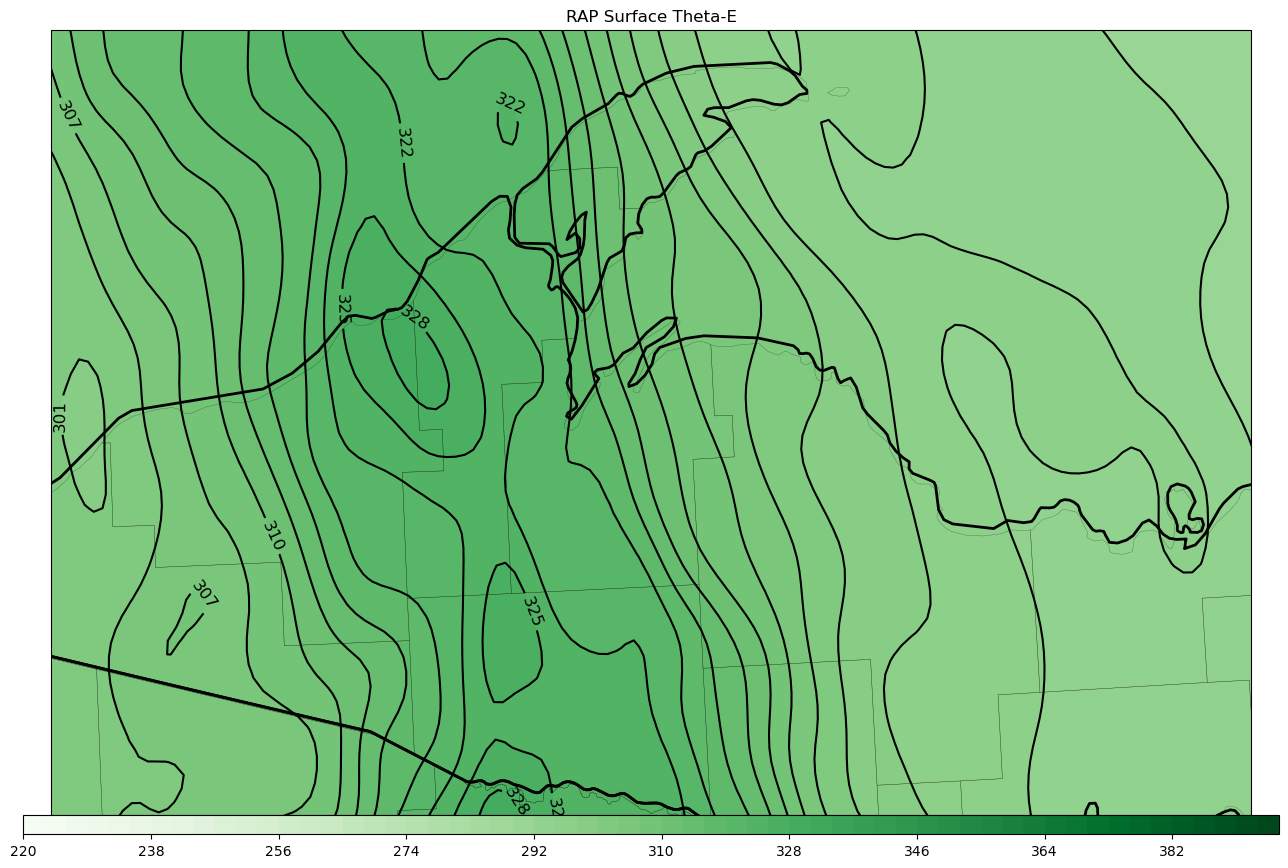

In [115]:
fig = plt.figure(figsize=(18, 12)) 
ax = fig.add_subplot(1, 1, 1, projection=crs) 
  
ax.set_extent([-90, -86.5, 46.0, 47.5], datacrs) 

ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=2)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha = 0.5)

orig_map=plt.cm.get_cmap('coolwarm')
  
reversed_map = orig_map.reversed()


cf = ax.contourf(thetae_h850_da.metpy.x, thetae_h850_da.metpy.y, ndimage.gaussian_filter(new_thetah1000_da, sigma=2, order=0),
                 levels=range(220, 400, 3), transform=ccrs.PlateCarree(), cmap='Greens')
plt.colorbar(cf, orientation='horizontal', extend=max, aspect=65, pad=0,
             extendrect='True', shrink=0.90)

c = ax.contour(thetae_h850_da.metpy.x, thetae_h850_da.metpy.y, ndimage.gaussian_filter(new_thetah1000_da, sigma=2, order=0), levels=range(220, 400, 3), colors='black', transform=datacrs)
ax.clabel(c, fontsize=12, inline=1, inline_spacing=4, fmt='%i')

plt.title('RAP Surface Theta-E')
plt.show()

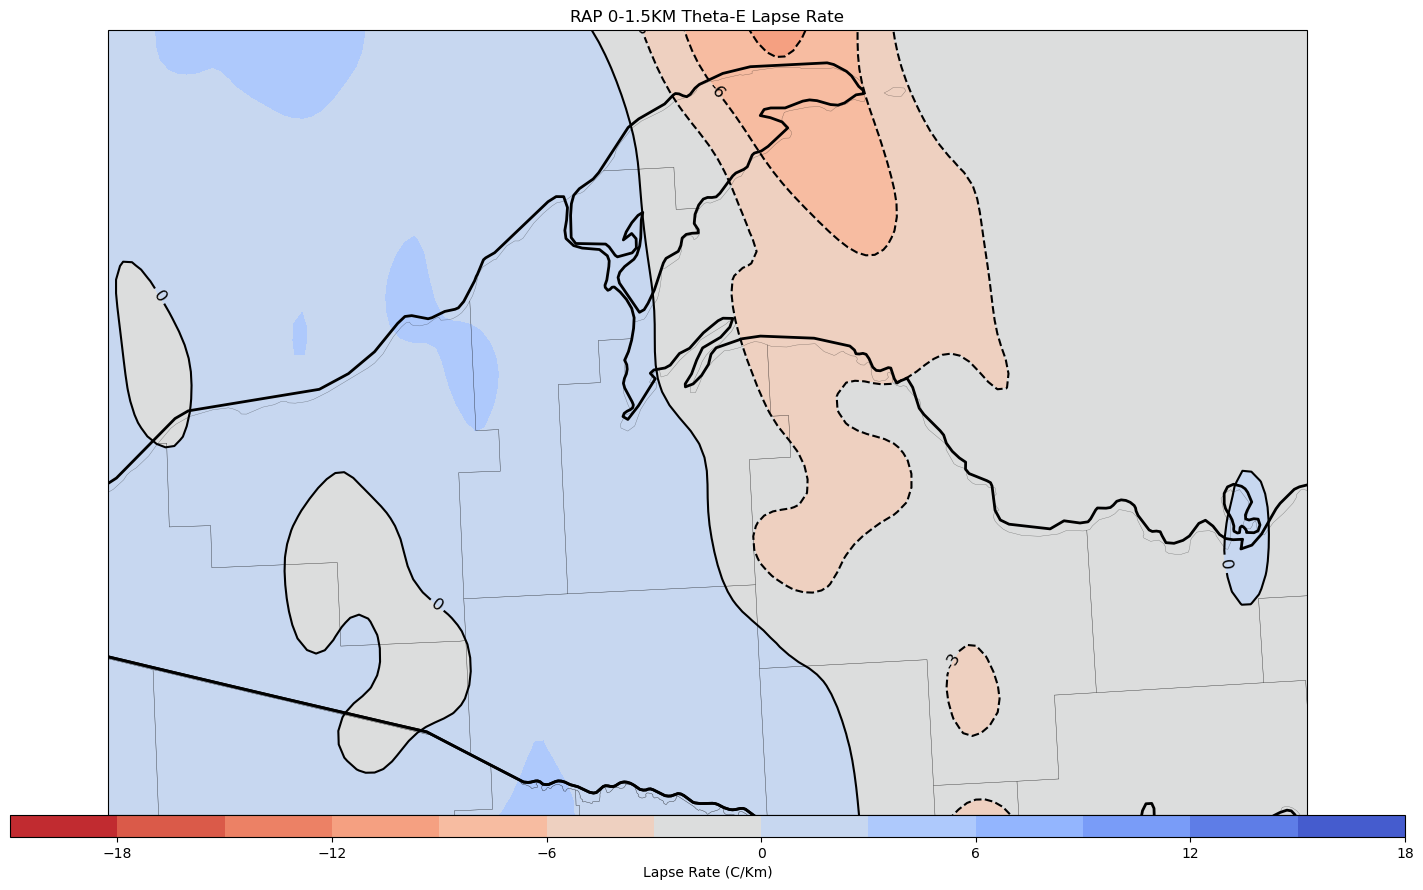

In [111]:
fig = plt.figure(figsize=(18, 12)) 
ax = fig.add_subplot(1, 1, 1, projection=crs) 
  
ax.set_extent([-90, -86.5, 46.0, 47.5], datacrs) 

ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=2)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha = 0.5)

orig_map=plt.cm.get_cmap('coolwarm')
  
reversed_map = orig_map.reversed()


cf = ax.contourf(thetae_h850_da.metpy.x, thetae_h850_da.metpy.y, ndimage.gaussian_filter(new_theta_lapserate_1500, sigma=2, order=0),
                 levels=range(-21, 21, 3), transform=ccrs.PlateCarree(), cmap=reversed_map)
plt.colorbar(cf, orientation='horizontal', extend=max, aspect=65, pad=0,
             extendrect='True', label = 'Lapse Rate (C/Km)')

c = ax.contour(thetae_h850_da.metpy.x, thetae_h850_da.metpy.y, ndimage.gaussian_filter(new_theta_lapserate_1500, sigma=2, order=0), levels=range(-21, 3, 3), colors='black', transform=datacrs)
ax.clabel(c, fontsize=12, inline=1, inline_spacing=4, fmt='%i')

plt.title('RAP 0-1.5KM Theta-E Lapse Rate')
plt.show()

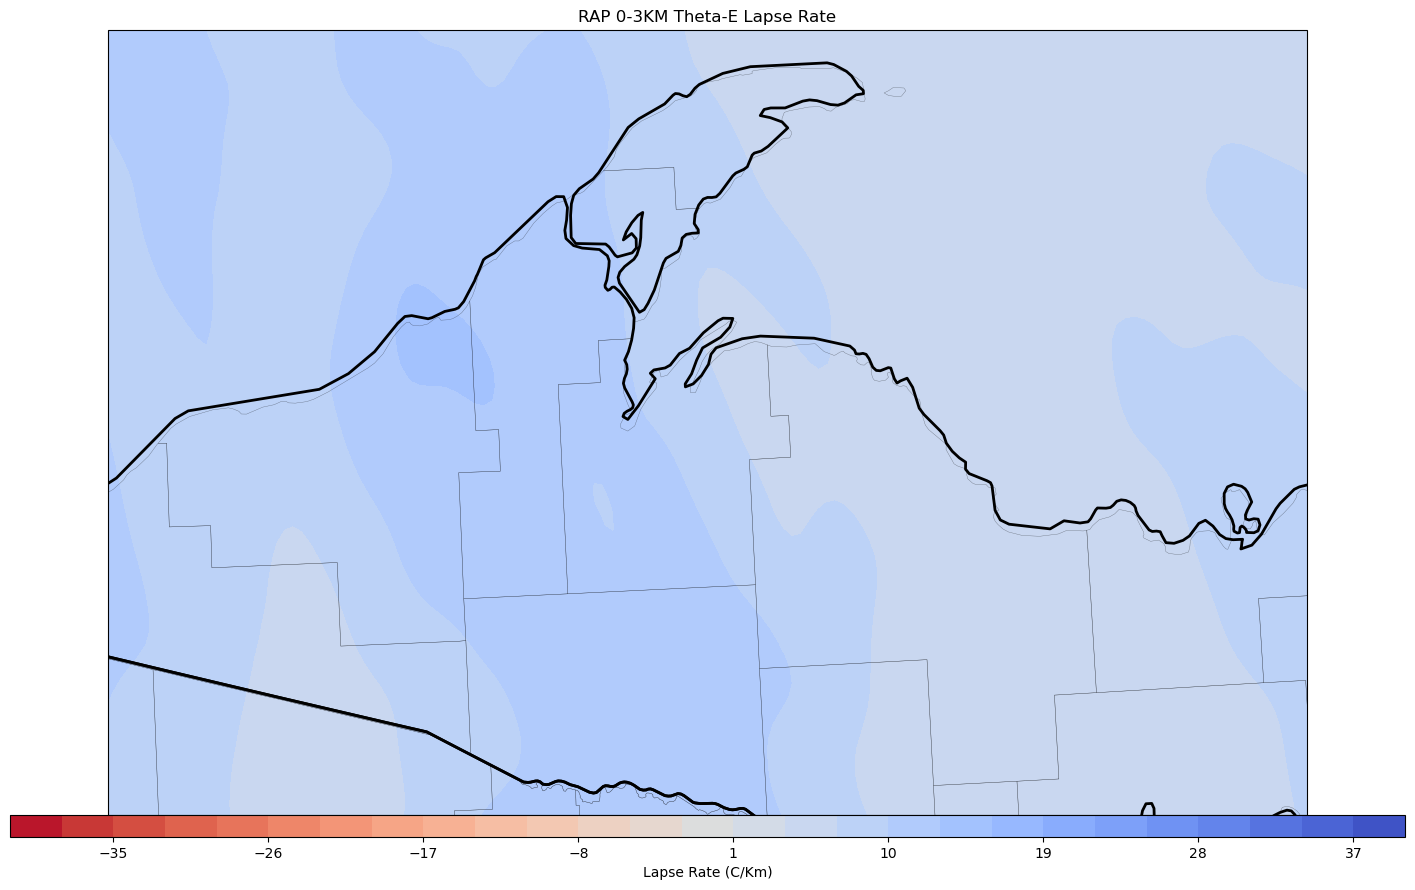

In [113]:
fig = plt.figure(figsize=(18, 12)) 
ax = fig.add_subplot(1, 1, 1, projection=crs) 
  
ax.set_extent([-90, -86.5, 46.0, 47.5], datacrs) 

ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=2)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25, alpha = 0.5)

orig_map=plt.cm.get_cmap('coolwarm')
  
reversed_map = orig_map.reversed()


cf = ax.contourf(thetae_h850_da.metpy.x, thetae_h850_da.metpy.y, ndimage.gaussian_filter(new_theta_lapserate_3000, sigma=2, order=0),
                 levels=range(-41, 41, 3), transform=ccrs.PlateCarree(), cmap=reversed_map)
plt.colorbar(cf, orientation='horizontal', extend=max, aspect=65, pad=0,
             extendrect='True', label = 'Lapse Rate (C/Km)')

c = ax.contour(thetae_h850_da.metpy.x, thetae_h850_da.metpy.y, ndimage.gaussian_filter(new_theta_lapserate_3000, sigma=2, order=0), levels=range(-40, 3, 3), colors='black', transform=datacrs)
ax.clabel(c, fontsize=12, inline=1, inline_spacing=4, fmt='%i')

plt.title('RAP 0-3KM Theta-E Lapse Rate')
plt.show()